In [1]:
#set up

#load libraries
library(gbm)
library(ggplot2)
library(GGally)
library(tidyverse)
library(cowplot)

#read in data
kcDat <- read.csv('~/Documents/kc_inspections.csv',header=TRUE)

#data cleaning
#assign some variables to be factors
cat_vars <- c('year','weekday','business_location_zip','american.traditional','mexican','american.new','italian',
             'mediterranean','indian','ethiopian','grocery','asian')
kcDat[,cat_vars] <- lapply(kcDat[,cat_vars],as.factor)


Loaded gbm 2.1.5
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ dplyr   0.7.6
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



## The data

The `kcDat` data frame contains information on restaurant inspections in King County, Washington between 2015 and 2019. The inspection data has been merged with Yelp review information and some other variables have been engineered.


 - Variables
      - `inspection_serial_num`: unique inspection identifier
      - `business_record_id`: unique restaurant identifer
      - `inspection_date`: date of inspection
      - `inspection_score`: score for inspection; higher scores mean there were more violations/penalties
      - `activity_time`: length of inspection in minutes
      - `year`: year the inspection occurred
      - `weekday`: day of week inspection occurred
      - `viol_count`: number of violations that occurred in inspection
      - `prev_score_1` through `prev_score_4`: score of four most recent previous inspections, prev_score_1 being most recent
      - `business_location_zip`: zip code where restaurant is located
      - `asian`: indicator that restaurant serves Asian food


## Data Visualization and Exploration

Let's first explore and visualize the data to understand it better and if there are any relationships between variables.

In [2]:
head(kcDat)

inspection_serial_num,business_record_id,inspection_date,inspection_score,activity_time,year,weekday,viol_count,prev_score_1,prev_score_2,⋯,ethiopian,indonesian,singaporean,grocery,asian,log_inspection_score,log_prev_score_1,log_prev_score_2,log_prev_score_3,log_prev_score_4
DAPXVWYJI,PR0001011,2015-03-30,10,25,2015,Monday,1,10,20,⋯,0,0,0,0,0,2.302585,2.302585,2.995732,2.484907,2.302585
DAIQD6JTB,PR0001011,2015-06-23,15,40,2015,Tuesday,2,10,10,⋯,0,0,0,0,0,2.708050,2.302585,2.302585,2.995732,2.484907
DAN2JKZZU,PR0001011,2016-03-21,20,30,2016,Monday,3,15,10,⋯,0,0,0,0,0,2.995732,2.708050,2.302585,2.302585,2.995732
DA0UJUF5K,PR0001011,2016-08-16,15,30,2016,Tuesday,2,20,15,⋯,0,0,0,0,0,2.708050,2.995732,2.708050,2.302585,2.302585
DACPGS7VE,PR0001011,2017-03-28,5,30,2017,Tuesday,1,15,20,⋯,0,0,0,0,0,1.609438,2.708050,2.995732,2.708050,2.302585
DASZN0RMO,PR0001011,2018-10-29,5,40,2018,Monday,1,5,15,⋯,0,0,0,0,0,1.609438,1.609438,2.708050,2.995732,2.708050


We can explore relationships between the continuous variables easily through scatterplots. `ggpairs` in the `GGally` package will create a grid of scatter plots between variables as well as give us the correlation and density plots.

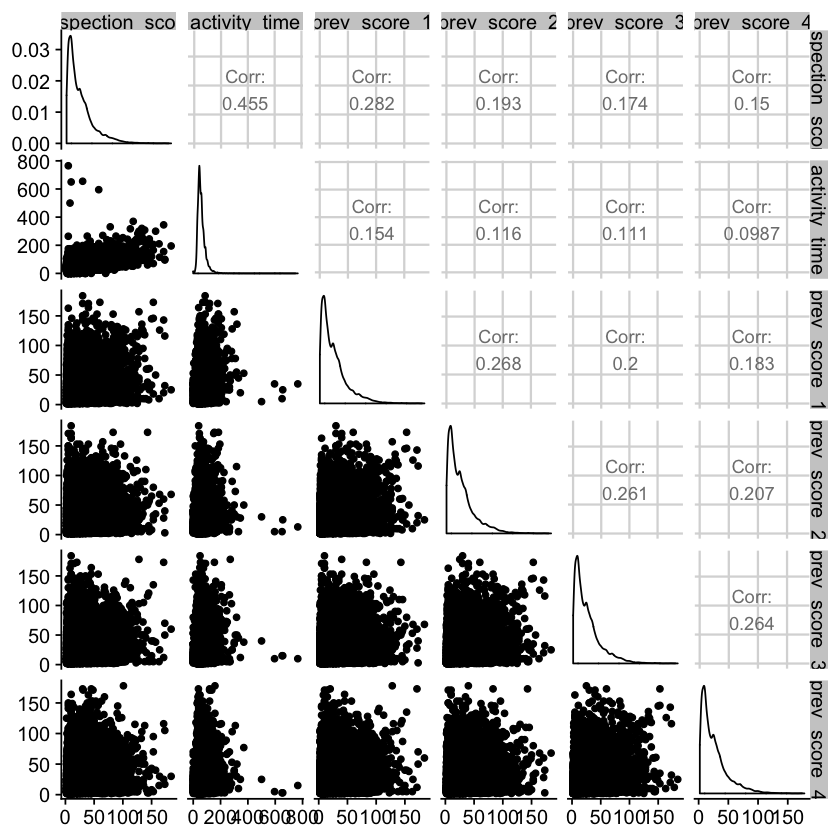

In [3]:
ggpairs(kcDat[,c('inspection_score','activity_time','prev_score_1','prev_score_2','prev_score_3',
                'prev_score_4')])

In [ ]:
#include other prompts for data exploration?

## Fit a model to predict inspection scores

We would like to fit a model that count of violations given in a future inspection. This model would be used to predict which restaurants are expected to have higher violation counts so inspectors could target these restaurants.

In [4]:
#get a random subset of data to fit model
set.seed(6183)
#take 80% of data to train - leave 20% to evaluate accuracy
train <- sample(1:nrow(kcDat),floor(nrow(kcDat)*.8),replace=FALSE)
train_sub <- kcDat[train,]
test_sub <- kcDat[-train,]

We'll first build a gradient boosted tree model using scores from previous inspections and the year and weekday the inspection occured.

In [5]:
predictors <- c('inspection_score','prev_score_1','prev_score_2','prev_score_3','prev_score_4','year','weekday')

gb <- gbm(inspection_score~prev_score_1 + prev_score_2 + prev_score_3 + prev_score_4 +
          year + weekday,
          data=train_sub[,predictors],distribution = "gaussian",n.trees = 1000,shrinkage = 0.02, interaction.depth = 2,cv.folds=6)

## Assess prediction ability

Now that we've fit a model, how well does it actually predict inspection scores? We'll calculate the square root of the mean squared error (RMSE) on the 20% of data we kept as a test set. 

In [7]:
#predicting for test set from fitted model
score_pred <- predict(gb,newdata=test_sub,n.trees=1000)

#calculating RMSE
sqrt(mean((score_pred - test_sub$inspection_score)^2))

[1] 21.3522

The RMSE is about 21.4, which means that on average, our model predicts an inspection score that is 20 points off the actual score given. This is a large margin of error so our model isn't predicting very well. What might be some reasons that the model performs poorly? 

We can also graphically show how well the model is predicting by plotting the predicted values against the observed values in two ways. The first is a calibration plot. This plot is typically used for models that predict probabilities of events occurring, but it can be adjusted for our use case. To create the calibration plot, we need to create bins from the predicted scores, and then calculate the mean of the observed scores in those created bins and plot the means against the midpoints of the bins.

In [8]:
#create bins by observed violation count
test_sub$prediction <- score_pred
test_sub$countCat <- ntile(test_sub$prediction,15)


midpoint <- function(x)mean(range(x))


calibration_data <- test_sub %>% 
                    group_by(countCat) %>%
                    summarize(meanScore = mean(inspection_score),
                              predMidpoint=midpoint(prediction),
                              n = n())

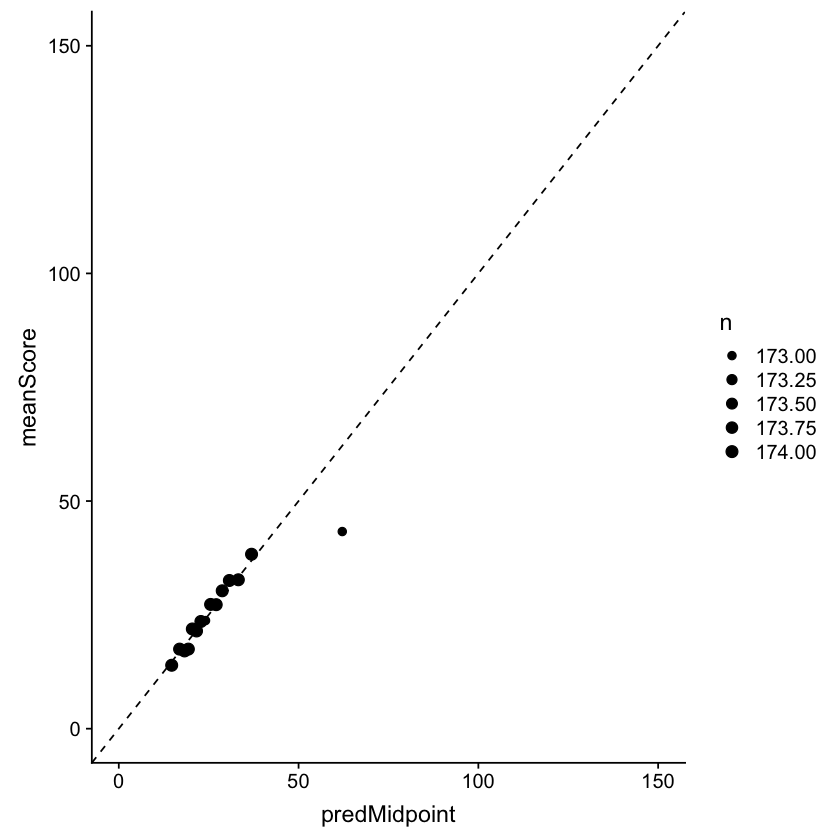

In [9]:
ggplot(calibration_data,aes(x=predMidpoint,y=meanScore)) + geom_point(aes(size = n)) + geom_abline(linetype = "dashed") +
    scale_x_continuous(limits = c(0, 150)) +
    scale_y_continuous(limits = c(0, 150)) +
    scale_size_continuous(range = c(2,  3))


For the second plot, the actual counts can be plotted against the predicted scores themselves. What does this plot tell you about the predictive ability of the model?

Warning message:
“Removed 1 rows containing missing values (geom_point).”

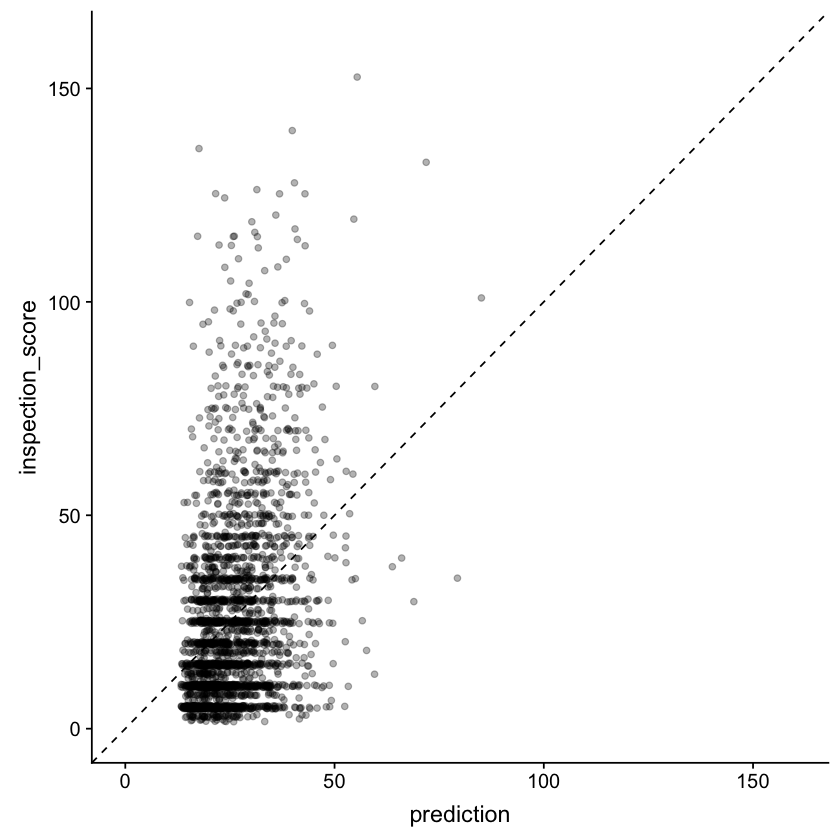

In [10]:
ggplot(test_sub,aes(x=prediction,y=inspection_score)) + geom_jitter(alpha=.3) + geom_abline(linetype = "dashed") +
  
  scale_x_continuous(limits = c(0, 160)) +
  scale_y_continuous(limits = c(0, 160))

Variable importance measures can be used to see which variables are driving the predictive ability of the model. The importance measure (rel.inf) used here is based off the number of times a variable is used for splitting the trees in the model, weighted by the squared improvement to the model after each split, averaged over all the trees in the model. Which variable seems to be driving the predictive ability of this model? Why might this variable have a lot of influence on the predicted score?

,var,rel.inf
prev_score_1,prev_score_1,46.234821
prev_score_2,prev_score_2,16.620661
prev_score_3,prev_score_3,14.780867
prev_score_4,prev_score_4,9.726653
year,year,9.036411
weekday,weekday,3.600586


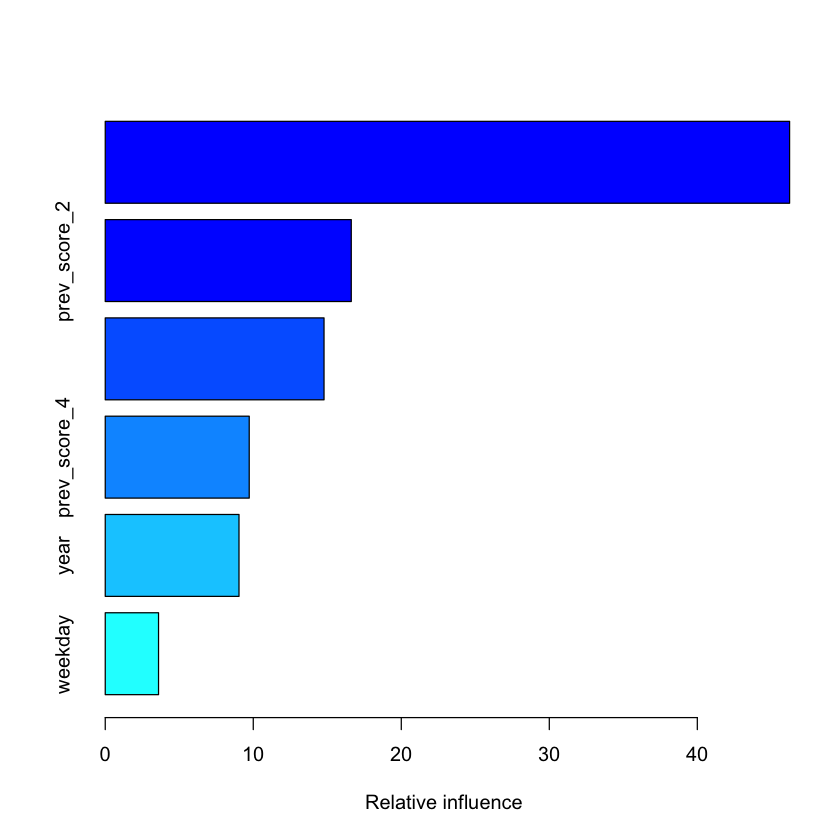

In [11]:
summary(gb)

## Adding zip code to the model

Let's add the zip code to the model to see if this improves the predictive ability.

In [12]:
#gradient boosted tree model with zip code
gb_zipcode <- gbm(inspection_score~prev_score_1 + prev_score_2 + prev_score_3 + prev_score_4 +
          year + weekday + business_location_zip,data=train_sub
          ,distribution = "gaussian",n.trees = 1000,shrinkage = 0.01, interaction.depth = 2)

In [13]:
#predict the inspection scores and calculate RMSE
score_pred_zip <- predict(gb_zipcode,newdata=test_sub,n.trees=1000)

sqrt(mean((score_pred_zip-test_sub$inspection_score)^2))

[1] 21.26831

There is only a very small decrease in RMSE when zip code is included in the model. We can also look at variable importance again to see if these measures have changed after including zip code.

,var,rel.inf
business_location_zip,business_location_zip,45.11776103
prev_score_1,prev_score_1,30.86863830
prev_score_2,prev_score_2,7.91659464
year,year,7.04205782
prev_score_3,prev_score_3,5.23079767
prev_score_4,prev_score_4,3.76278590
weekday,weekday,0.06136463


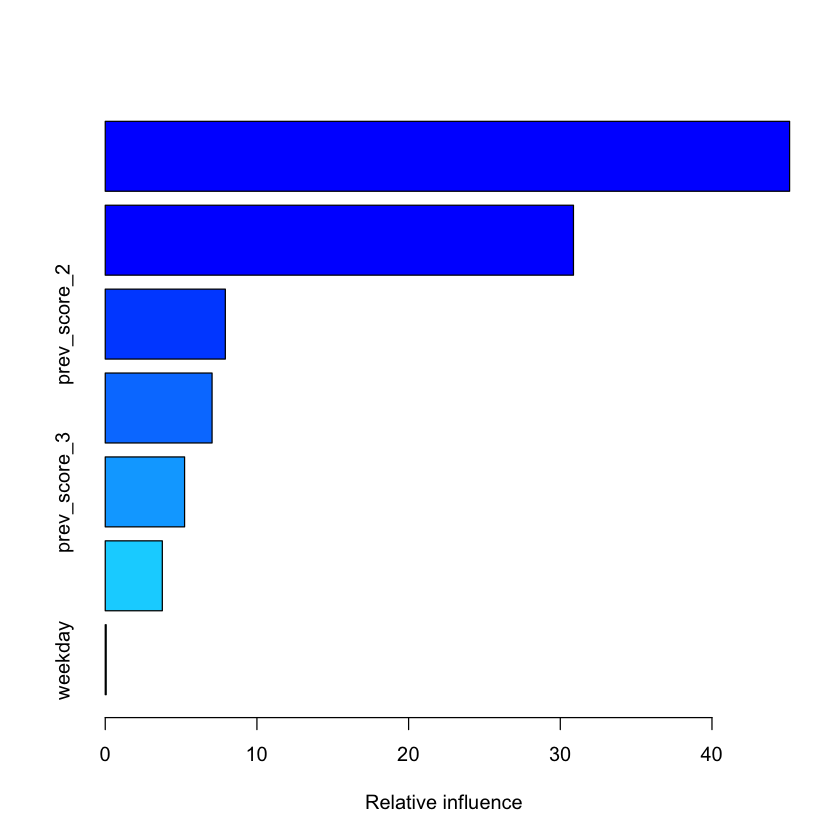

In [14]:
summary(gb_zipcode)

Zip codes seem to be the most influential variable now. However, inspectors are assigned by zip code, and some inspectors are more harsh than others when grading (see https://www.thestranger.com/seattle/mr-clean/Content?oid=568012 ). What will this mean if the allocation of resources for inspections is dictated by a model that takes zip code into account when predicting scores?

Since zip code became the most influential variable but the predictive ability hasn't changed, what might this mean about the information the other variables in the model are representing?

## Including cuisine category

Let's try adding the Asian restaurant indicator to see if this extra variable will improve accuracy.

In [15]:
gb_asian <- gbm(inspection_score~prev_score_1 + prev_score_2 + prev_score_3 + prev_score_4 +
          year + weekday + asian,data=train_sub
          ,distribution = "gaussian",n.trees = 1000,shrinkage = 0.01, interaction.depth = 2)

In [16]:
#predict the inspection scores and calculate RMSE
score_pred_asian <- predict(gb_asian,newdata=test_sub,n.trees=1000)
test_sub$prediction_w_asian <- score_pred_asian

sqrt(mean((score_pred_asian-test_sub$inspection_score)^2))

[1] 21.12054

,var,rel.inf
prev_score_1,prev_score_1,45.826857
prev_score_2,prev_score_2,13.609627
asian,asian,13.000466
prev_score_3,prev_score_3,9.607526
year,year,9.228371
prev_score_4,prev_score_4,6.695755
weekday,weekday,2.031398


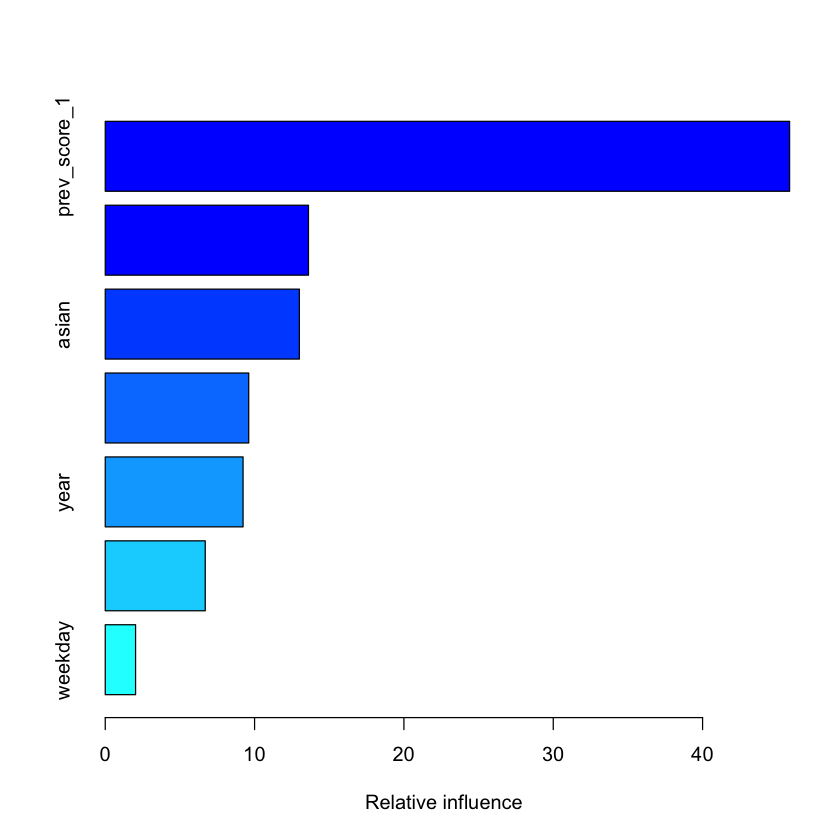

In [17]:
#look at variable importance
summary(gb_asian)

Looking at the RMSE, including the Asian food indicator doesn't seem to improve the model either. It is the third most influential variable, but the relative influence compared to the most recent inspection score is still low. We can look futher into how the Asian food indicator is affected the prediction by recreating the calibration plot and predicted vs actual plots from before.

In [18]:
test_sub$countCatAsian <- ntile(test_sub$prediction_w_asian,15)

#data for calibration plot for model with asian 
calibration_data_asian <- test_sub %>% 
                    group_by(countCatAsian) %>%
                    summarize(meanScore = mean(inspection_score),
                              predMidpoint=midpoint(prediction),
                              n = n())  

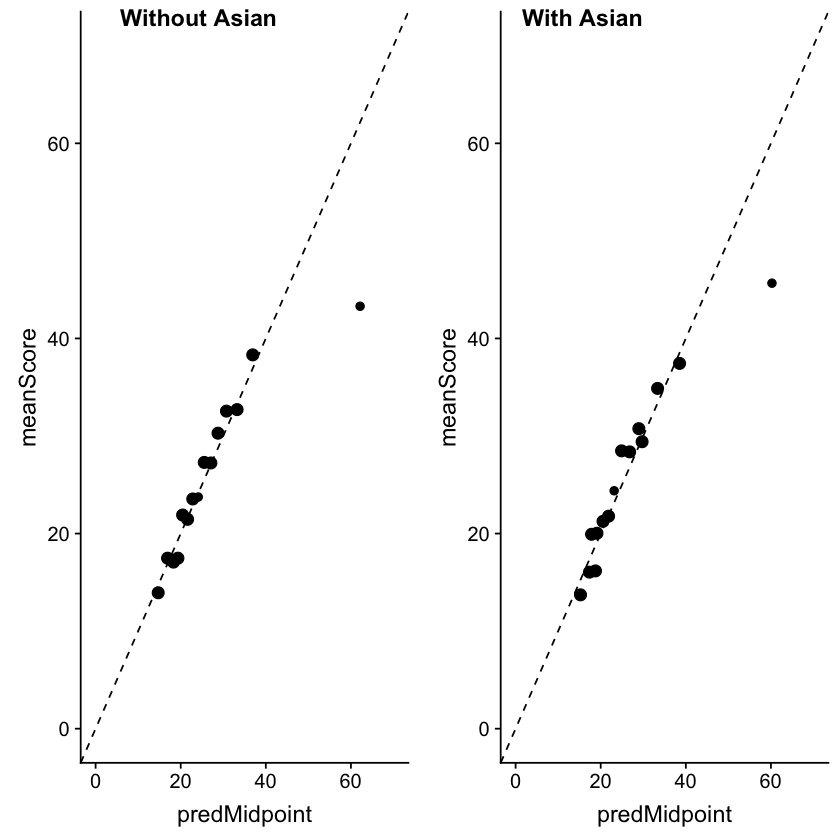

In [20]:
calib_plot  <- ggplot(calibration_data,aes(x=predMidpoint,y=meanScore)) + geom_point(aes(size = n)) + geom_abline(linetype = "dashed") +
    scale_x_continuous(limits = c(0, 70)) +
    scale_y_continuous(limits = c(0, 70)) +
    scale_size_continuous(range = c(2,  3)) + theme(legend.position='none')

calib_plot_asian <- ggplot(calibration_data_asian,aes(x=predMidpoint,y=meanScore)) + geom_point(aes(size = n)) + geom_abline(linetype = "dashed") +
    scale_x_continuous(limits = c(0, 70)) +
    scale_y_continuous(limits = c(0, 70)) +
    scale_size_continuous(range = c(2,  3)) + theme(legend.position='none')

plot_grid(calib_plot, calib_plot_asian,align='hv',labels=c('Without Asian','With Asian'),label_x=0.1)


Warning message:
“Removed 2 rows containing missing values (geom_point).”

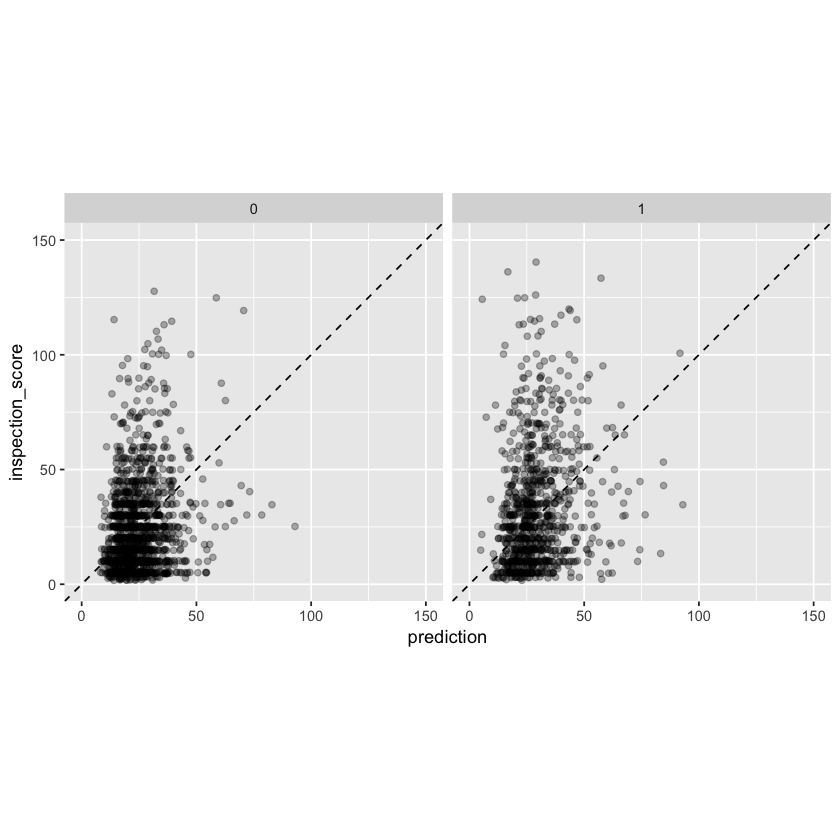

In [30]:
ggplot(test_sub,aes(x=prediction,y=inspection_score)) + geom_abline(linetype = "dashed") +
  geom_jitter(alpha=0.3) +
  facet_grid(cols = vars(asian)) + coord_fixed() +
  scale_x_continuous(limits = c(0, 150)) +
  scale_y_continuous(limits = c(0, 150))